In [1]:
import gc

import numpy as np
import pandas as pd

import datetime

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import lightgbm as lgb
from scipy.stats import linregress

from tqdm import tqdm

In [25]:
train = pd.read_pickle('features/train_created_feature.pkl')

In [26]:
train = train.sort_values("date")
train = train.reset_index(drop=True)

In [27]:
print(train.shape)
train.head()

(37558961, 52)


,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,date,wm_yr_wk,...,salesrolling_MEAN_t90,salesrolling_MEAN_t180,salesrolling_MIN_t7,salesrolling_MIN_t30,salesrolling_MIN_t60,salesrolling_MAX_t7,salesrolling_MAX_t30,salesrolling_MAX_t60,salesrolling_SKEW_t30,salesrolling_KURT_t30
0,HOBBIES_1_002_CA_1_validation,1438,3,1,0,0,d_208,1,2011-08-24,11130,...,0.088867,0.044434,0.0,0.0,0.0,1.0,1.0,1.0,1.580078,0.527344
1,HOUSEHOLD_2_324_TX_3_validation,2856,6,2,6,1,d_208,0,2011-08-24,11130,...,0.066650,0.055542,0.0,0.0,0.0,0.0,1.0,1.0,5.476562,30.000000
2,HOUSEHOLD_2_325_TX_3_validation,2857,6,2,6,1,d_208,0,2011-08-24,11130,...,0.544434,0.488770,0.0,0.0,0.0,2.0,4.0,4.0,2.095703,5.191406
3,HOUSEHOLD_2_327_TX_3_validation,2859,6,2,6,1,d_208,0,2011-08-24,11130,...,0.133301,0.161133,0.0,0.0,0.0,1.0,1.0,1.0,3.660156,12.203125
4,HOUSEHOLD_2_328_TX_3_validation,2860,6,2,6,1,d_208,0,2011-08-24,11130,...,0.166626,0.233276,0.0,0.0,0.0,1.0,1.0,1.0,2.808594,6.308594


In [60]:
print("start date:", train['date'].min())
print("end date:", train['date'].max())
print("data shape:", train.shape)

start date: 2011-08-24 00:00:00
end date: 2016-04-24 00:00:00
data shape: (37558961, 52)


In [45]:
class CustomTimeSeriesSplitter:
    def __init__(self, n_splits=5, train_days=80, test_days=20, dt_col="date"):
        self.n_splits = n_splits
        self.train_days = train_days
        self.test_days = test_days
        self.dt_col = dt_col

    def split(self, X, y=None, groups=None):
        sec = (X[self.dt_col] - X[self.dt_col][0]).dt.total_seconds()
        duration = sec.max() - sec.min()

        train_sec = 3600 * 24 * self.train_days
        test_sec = 3600 * 24 * self.test_days
        total_sec = test_sec + train_sec
        step = (duration - total_sec) / (self.n_splits - 1)

        for idx in range(self.n_splits):
            train_start = idx * step
            train_end = train_start + train_sec
            test_end = train_end + test_sec

            if idx == self.n_splits - 1:
                test_mask = sec >= train_end
            else:
                test_mask = (sec >= train_end) & (sec < test_end)

            train_mask = (sec >= train_start) & (sec < train_end)
            test_mask = (sec >= train_end) & (sec < test_end)

            yield sec[train_mask].index.values, sec[test_mask].index.values

    def get_n_splits(self):
        return self.n_splits


def plot_cv_indices(cv, X, y, dt_col, lw=10):
    n_splits = cv.get_n_splits()
    plt.figure()
    fig, ax = plt.subplots(figsize=(20, n_splits))

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            X[dt_col],
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=plt.cm.coolwarm,
            vmin=-0.2,
            vmax=1.2,
        )

    # Formatting
    MIDDLE = 15
    LARGE = 20
    ax.set_xlabel("Datetime", fontsize=LARGE)
    ax.set_xlim([X[dt_col].min(), X[dt_col].max()])
    ax.set_ylabel("CV iteration", fontsize=LARGE)
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=MIDDLE)
    ax.set_title("{}".format(type(cv).__name__), fontsize=LARGE)
    fig.savefig("figure/cv_indices.png")
    plt.show()

In [46]:
cv_params = {
        "n_splits": 5,
        "train_days": 365 * 2,
        "test_days": 28,
        "dt_col": 'date',
    }
cv = CustomTimeSeriesSplitter(**cv_params)

<Figure size 432x288 with 0 Axes>

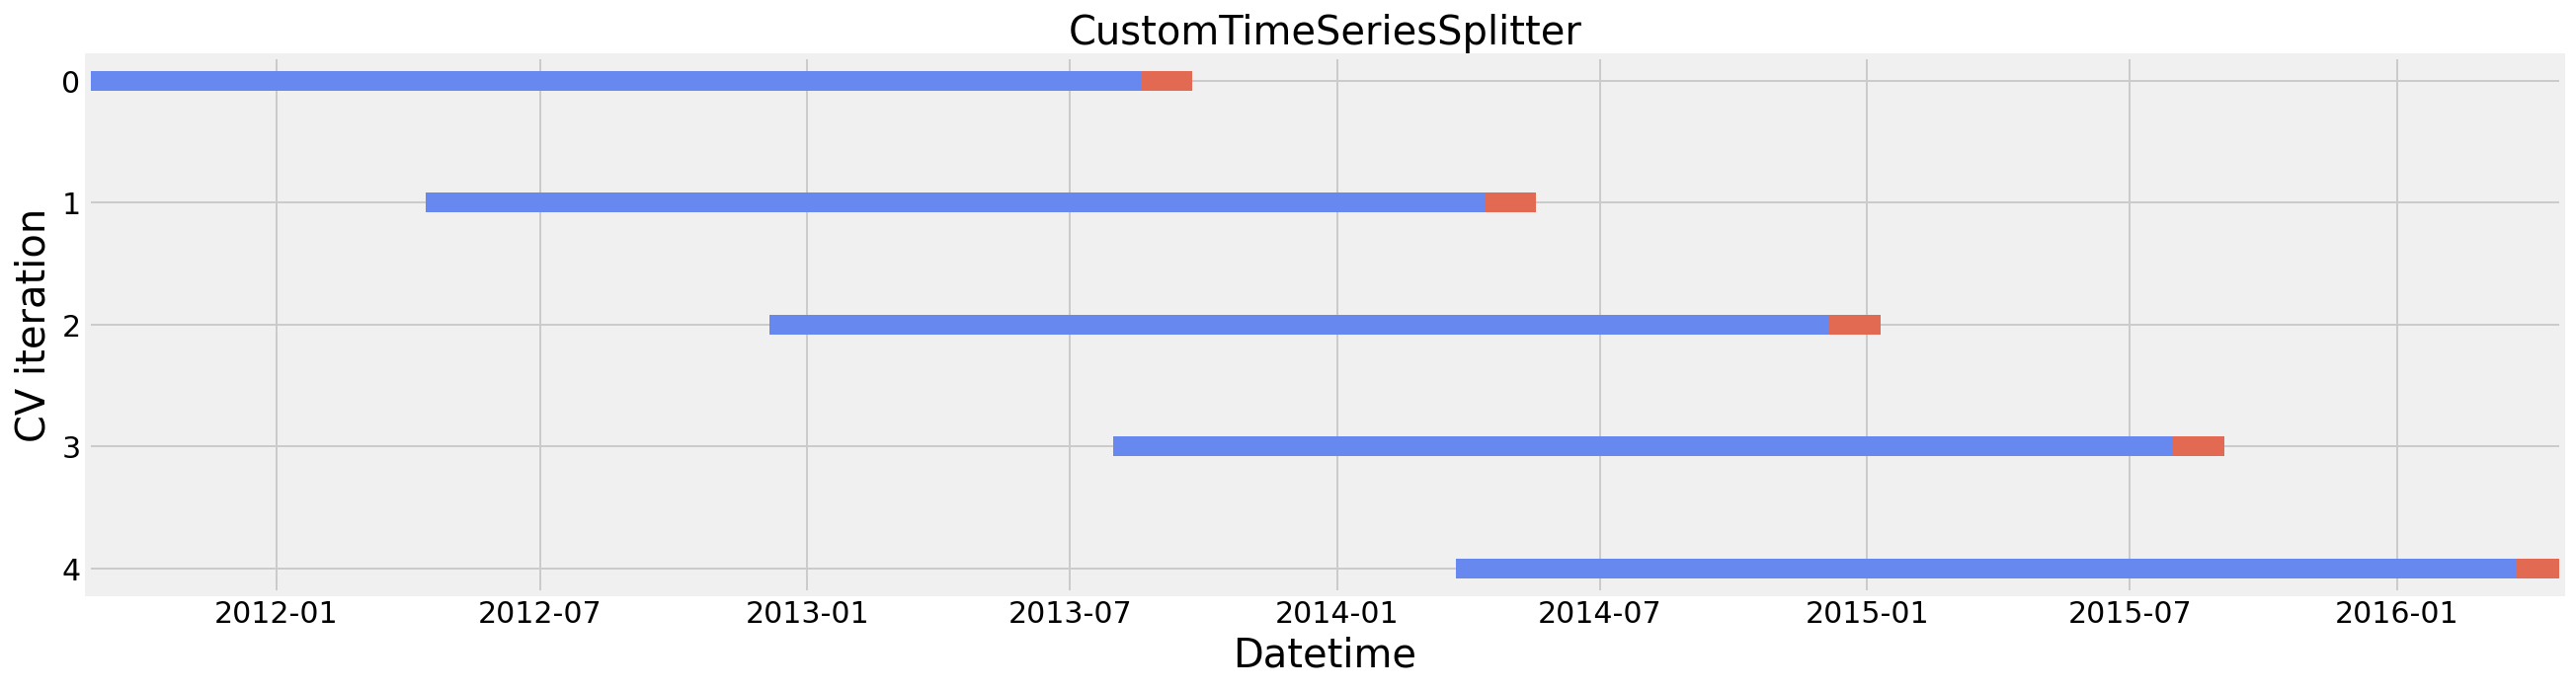

In [47]:
plot_cv_indices(cv, train.iloc[::1000][['date']].reset_index(drop=True), None, 'date')

In [51]:
features = train.columns.tolist()
cols_to_drop = ['id', 'd', 'date', 'sales']
cols_to_drop += ['salesrolling_MIN_t7',
 'salesrolling_MIN_t30',
 'salesrolling_MIN_t60',
 'salesrolling_MAX_t7',
 'salesrolling_MAX_t30',
 'salesrolling_MAX_t60']

features = [f for f in features if f not in cols_to_drop]

PRED_INTERVAL = 28
eval_date = train['date'].max() - datetime.timedelta(days=PRED_INTERVAL)
eval_mask = (train["date"] > "2016-04-24")

X, y = train[~eval_mask][['date'] + features], train[~eval_mask]['sales']
X_eval, y_eval = train[eval_mask][['date'] + features], train[eval_mask]['sales']

In [52]:
def train_lgb(bst_params, fit_params, X, y, cv, drop_when_train=None):
    models = []

    if drop_when_train is None:
        drop_when_train = []

    for idx_fold, (idx_trn, idx_val) in enumerate(cv.split(X, y)):
        print(f"\n---------- Fold: ({idx_fold + 1} / {cv.get_n_splits()}) ----------\n")

        X_trn, X_val = X.iloc[idx_trn], X.iloc[idx_val]
        y_trn, y_val = y.iloc[idx_trn], y.iloc[idx_val]
        train_set = lgb.Dataset(X_trn.drop(drop_when_train, axis=1), label=y_trn)
        val_set = lgb.Dataset(X_val.drop(drop_when_train, axis=1), label=y_val)

        model = lgb.train(
            bst_params,
            train_set,
            valid_sets=[train_set, val_set],
            valid_names=["train", "valid"],
            **fit_params,
        )
        models.append(model)

        del idx_trn, idx_val, X_trn, X_val, y_trn, y_val
        gc.collect()

    return models

In [53]:
bst_params = {
    "boosting_type": "gbdt",
    "metric": "rmse",
    "objective": "regression",
    "n_jobs": -1,
    "seed": 42,
    "learning_rate": 0.3,
    "bagging_fraction": 0.75,
    "bagging_freq": 10,
    "colsample_bytree": 0.75,
}

fit_params = {
    "num_boost_round": 100_000,
    "early_stopping_rounds": 50,
    "verbose_eval": 100,
}

models = train_lgb(
    bst_params, fit_params, X, y, cv, drop_when_train=['date']
)

# del X_train, y_train
# gc.collect()


---------- Fold: (1 / 5) ----------

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	train's rmse: 2.95347	valid's rmse: 4.42235

---------- Fold: (2 / 5) ----------

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.81781	valid's rmse: 2.6431
Early stopping, best iteration is:
[80]	train's rmse: 2.84313	valid's rmse: 2.63761

---------- Fold: (3 / 5) ----------

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[8]	train's rmse: 2.89557	valid's rmse: 2.56542

---------- Fold: (4 / 5) ----------

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 2.45485	valid's rmse: 2.32866
[200]	train's rmse: 2.38279	valid's rmse: 2.31876
Early stopping, best iteration is:
[196]	train's rmse: 2.38456	valid's rmse: 2.31685

---------- Fold: (5 / 5) ----------

Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 

In [54]:
def get_feature_importance(models):
    feature_importance = pd.DataFrame(
        [model.feature_importance() for model in models],
        columns=models[0].feature_name()
    ).T

    feature_importance['Agerage_Importance'] = feature_importance.iloc[:, :len(models)].mean(axis=1)
    feature_importance['importance_std'] = feature_importance.iloc[:, :len(models)].std(axis=1)
    feature_importance.sort_values(by='Agerage_Importance', inplace=True)
    return feature_importance

def plot_importance(models, max_num_features=50, figsize=(12, 15)):
    feature_importance = get_feature_importance(models)
    plt.figure(figsize=figsize)

    feature_importance[-max_num_features:].plot(
        kind='barh', title='Feature importance', figsize=figsize,
        y='Agerage_Importance', xerr='importance_std',
        grid=True, align="center"
    )
    plt.legend()
    plt.savefig('figure/importance.png')
    plt.show()

<Figure size 864x1080 with 0 Axes>

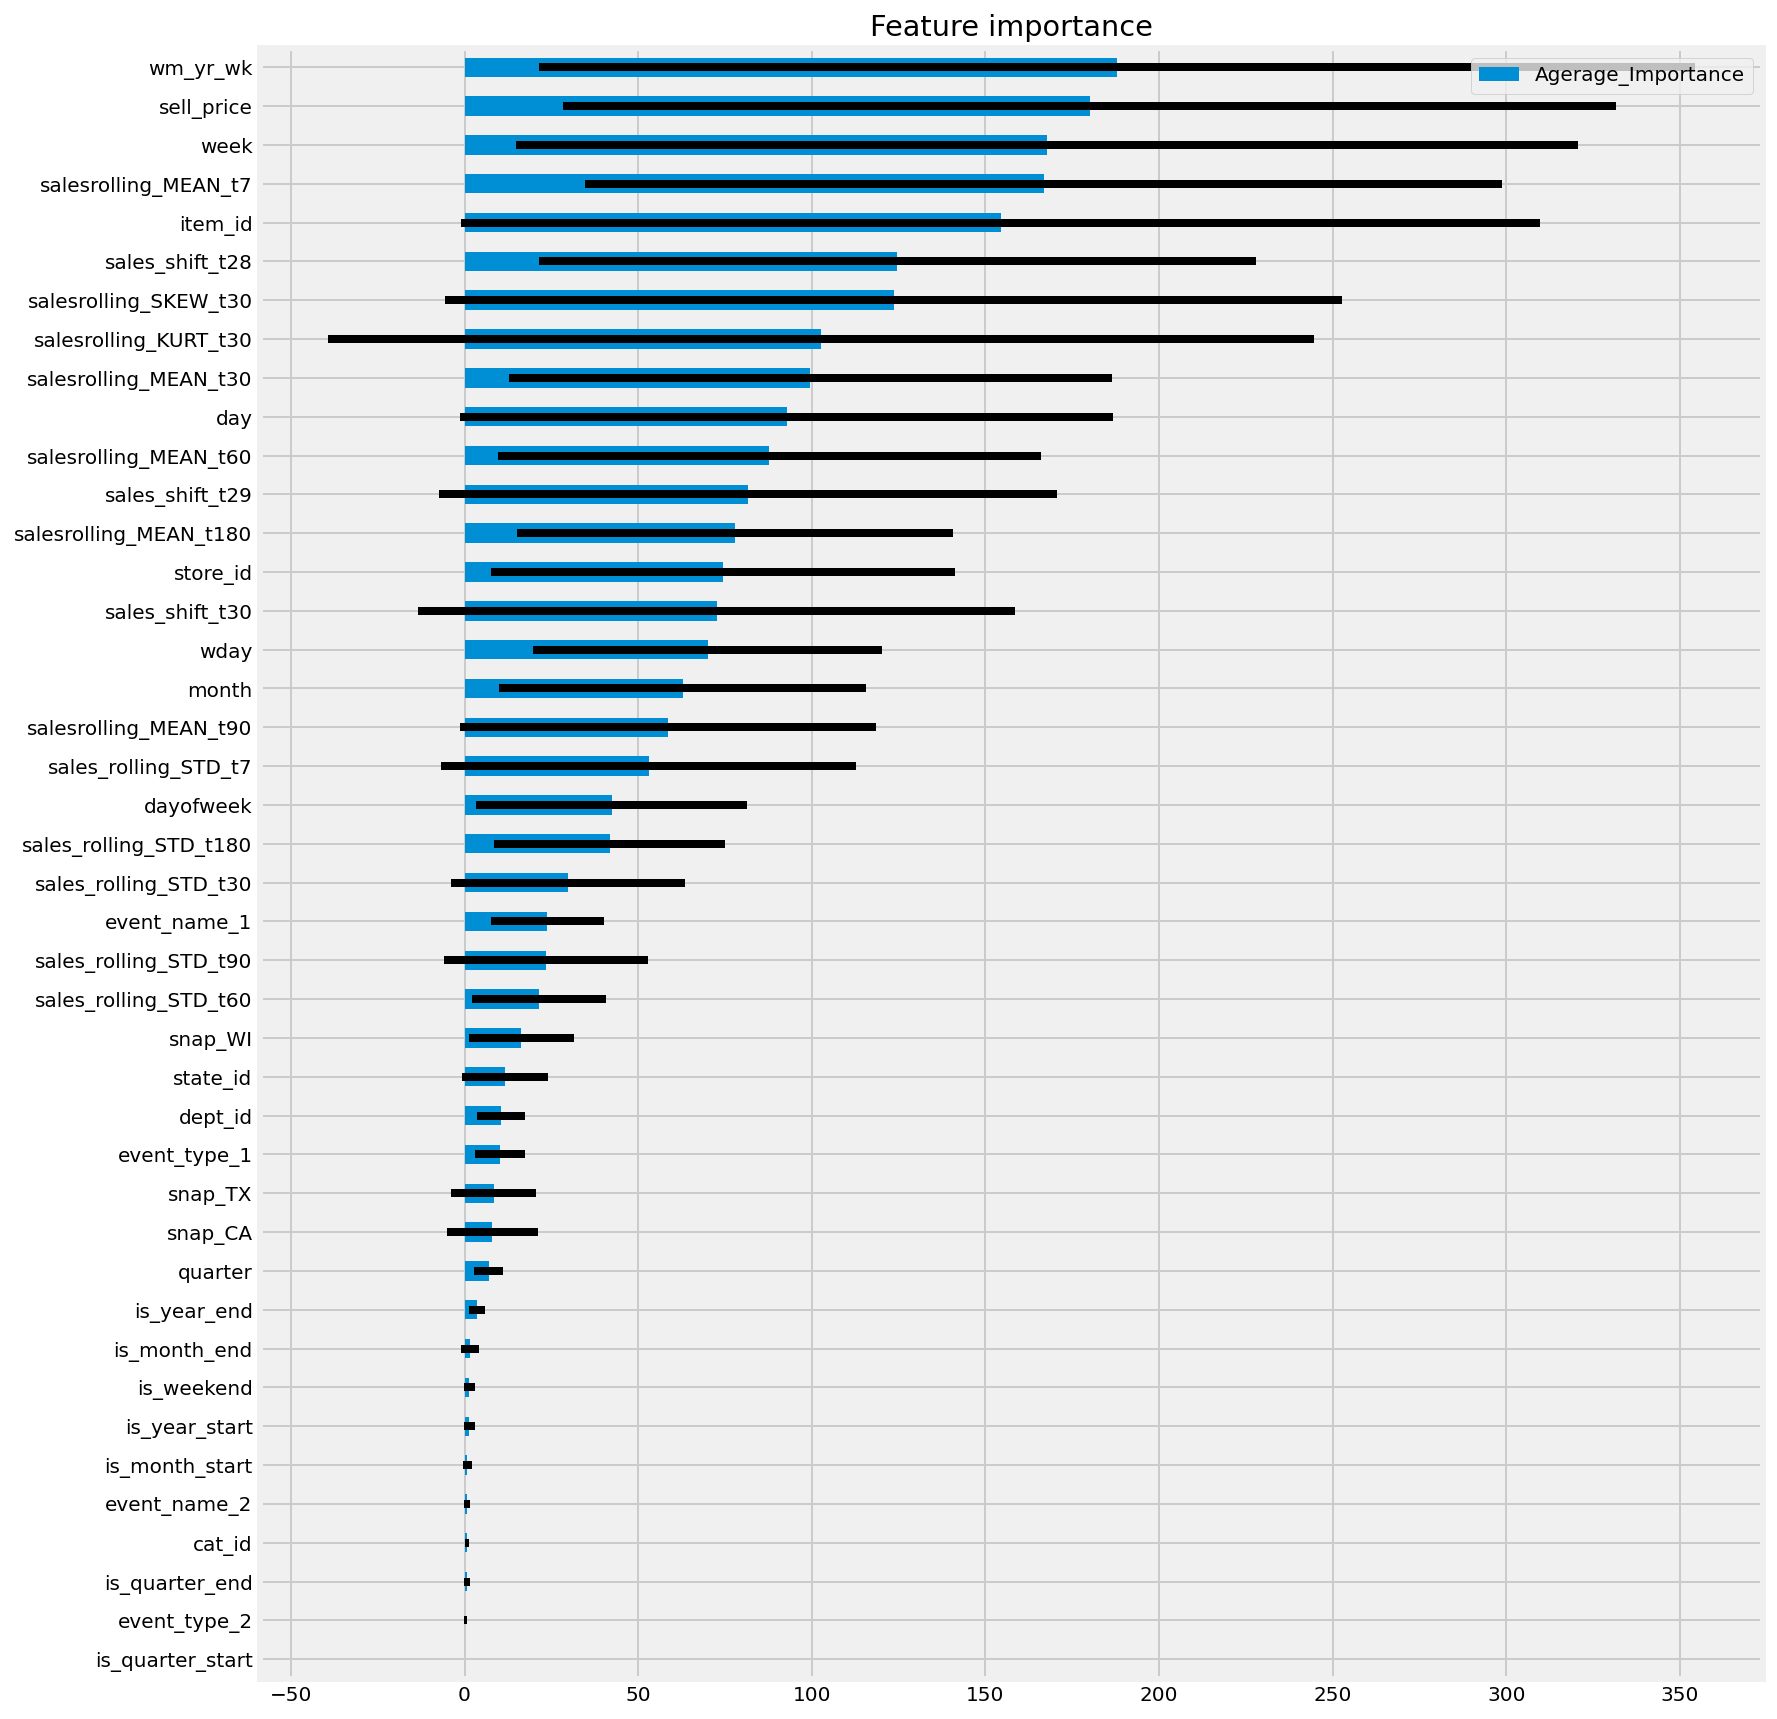

In [55]:
plot_importance(models)

In [23]:
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

In [24]:
# imp_type = "gain"
# importances = np.zeros(X_test.shape[1])
# preds = np.zeros(X_test.shape[0])

# for model in models:
#     preds += model.predict(X_test)
#     importances += model.feature_importance(imp_type)

# preds = preds / cv.get_n_splits()
# importances = importances / cv.get_n_splits()